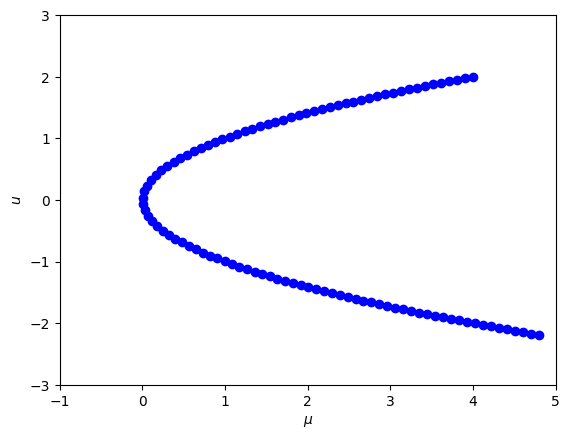

In [7]:
import numpy as np
import matplotlib.pyplot as plt

try:  # Optional display support for notebooks
    from IPython.display import DisplayHandle
except ImportError:
    DisplayHandle = None


def f0(u, mu):
    """Vanilla scalar function f(u, mu) = mu - u**2."""
    return mu - u**2


def df0(u, mu):
    """Derivative of f0 with respect to u."""
    return -2.0 * u


def f(v, v_star, sec):
    """Full system with secant constraint."""
    return np.array([
        v[1] - v[0] ** 2,
        np.dot(v - v_star, sec),
    ])


def df(v, sec):
    """Jacobian of the full system."""
    return np.array([
        [-2.0 * v[0], 1.0],
        [sec[0], sec[1]],
    ])


def main():
    tol = 1e-6
    max_iter = 10
    ds = 1e-1

    v0 = np.array([2.0, 4.0])

    # Baby continuation step to find the second equilibrium
    v1 = v0 + np.array([0.0, -ds])
    u1, mu1 = v1
    error = 1.0
    iter_count = 0
    while error > tol and iter_count < max_iter:
        res = f0(u1, mu1)
        error = abs(res)
        u1 -= res / df0(u1, mu1)
        iter_count += 1
    v1[0] = u1

    mus = [v0[1], v1[1]]
    us = [v0[0], v1[0]]

    fig, ax = plt.subplots()
    ax.set_xlabel(r"$\mu$")
    ax.set_ylabel(r"$u$")
    ax.set_xlim([-1, 5])
    ax.set_ylim([-3, 3])
    (line,) = ax.plot(mus, us, "bo-")
    display_handle = None
    if DisplayHandle is not None:
        display_handle = DisplayHandle()
        display_handle.display(fig)
    else:
        plt.show(block=False)
        fig.canvas.draw()
        fig.canvas.flush_events()

    # Secant continuation iterations
    cont_iter = 0
    while cont_iter < 100:
        sec = (v1 - v0) / np.linalg.norm(v1 - v0)
        v_star = v1 + ds * sec
        v = v_star.copy()
        error = 1.0
        iter_count = 0

        while error > tol and iter_count < max_iter:
            res = f(v, v_star, sec)
            error = np.linalg.norm(res)
            v -= np.linalg.solve(df(v, sec), res)
            iter_count += 1

        if error >= tol and iter_count >= max_iter:
            print(f"Newton does not converge at mu={v[1]:.6g}")
            break

        mus.append(v[1])
        us.append(v[0])
        line.set_data(mus, us)
        if display_handle is not None:
            display_handle.update(fig)
        else:
            fig.canvas.draw_idle()
            fig.canvas.flush_events()
            plt.pause(0.01)

        v0 = v1.copy()
        v1 = v.copy()
        cont_iter += 1

    if display_handle is None:
        plt.show()


if __name__ == "__main__":
    main()